In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="staticrealanorouterdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [9]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

1client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy
2client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,1client_0attacker_infinite_requests_many_trial...,3,5,1,originserver,pc2133,ubuntu1804-std
1,1client_0attacker_infinite_requests_many_trial...,3,6,4,proxy,microcloud,ubuntu1804-std
2,1client_0attacker_infinite_requests_many_trial...,3,2,5,client1,pc3000,ubuntu1804-std
3,2client_0attacker_infinite_requests_many_trial...,3,12,1,originserver,pc2133,ubuntu1804-std
4,2client_0attacker_infinite_requests_many_trial...,3,13,4,proxy,microcloud,ubuntu1804-std
5,2client_0attacker_infinite_requests_many_trial...,3,9,5,client1,pc3000,ubuntu1804-std
6,2client_0attacker_infinite_requests_many_trial...,3,10,6,client2,pc3000,ubuntu1804-std


In [4]:
exp_id = "1client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'client1': 5, 'originserver': 1, 'proxy': 4}
{'client1': 2, 'originserver': 5, 'proxy': 6}
{5}
{2}
4


In [5]:
client_messages_sql = f"""
SELECT
    e.observe_timestamp,
    e.message_marker,
    e.trial,
	m.src_id,
	m.dst_id,
    m.size_bytes
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["dst_id"].isin(client_node_ids), df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by=["trial", "message_marker"]).agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max"),
                                              src_id=("src_id", "max"),
                                              max_size_bytes=("size_bytes", "max")).reset_index()
rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3

rps_records = []

for t in rtts_df["trial"].unique():
    print(f"Trial {t}")
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        print(f"-- Client {client_number}")
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        client_trial_df["count"] = np.arange(1, len(client_trial_df) + 1)
        print(client_trial_df.describe())
        average_rps = client_trial_df["count"].max() / (client_trial_df["timestamp"].max() - client_trial_df["timestamp"].min())
        print(f"\naverage_rps={average_rps}")
        print()
        
        rps_records.append({
            "trial": t, 
            "src_id": src_id,
            "client_number": client_number,
            "average_rps": average_rps,
        })

# Add average rps per client per trial to the rtts df
rps_df = pd.DataFrame.from_records(rps_records)
rtts_df = rtts_df.merge(rps_df[["trial", "src_id", "average_rps"]], on=["trial", "src_id"], how="left")
        
rtts_df

Trial 1
-- Client 1
        trial  message_marker      rtt_sec     timestamp  src_id  \
count  1758.0     1758.000000  1758.000000  1.758000e+03  1758.0   
mean      1.0      879.500000     0.054356  1.638461e+09     5.0   
std       0.0      507.635204     0.003340  2.815656e+01     0.0   
min       1.0        1.000000     0.053660  1.638461e+09     5.0   
25%       1.0      440.250000     0.054001  1.638461e+09     5.0   
50%       1.0      879.500000     0.054186  1.638461e+09     5.0   
75%       1.0     1318.750000     0.054424  1.638461e+09     5.0   
max       1.0     1758.000000     0.193213  1.638461e+09     5.0   

       max_size_bytes       rtt_ms        count  
count     1758.000000  1758.000000  1758.000000  
mean       108.370307    54.356359   879.500000  
std          0.605388     3.339732   507.635204  
min        106.000000    53.659916     1.000000  
25%        108.000000    54.000854   440.250000  
50%        108.000000    54.185629   879.500000  
75%        109.00

,trial,message_marker,rtt_sec,timestamp,src_id,max_size_bytes,rtt_ms,average_rps
0,1,1,0.193213,1.638461e+09,5,106,193.212748,17.984109
1,1,2,0.056776,1.638461e+09,5,106,56.776047,17.984109
2,1,3,0.055321,1.638461e+09,5,106,55.321217,17.984109
3,1,4,0.055906,1.638461e+09,5,106,55.906057,17.984109
4,1,5,0.056672,1.638461e+09,5,106,56.671858,17.984109
...,...,...,...,...,...,...,...,...
5264,3,1750,0.053947,1.638461e+09,5,109,53.946972,17.942068
5265,3,1751,0.053736,1.638461e+09,5,109,53.735971,17.942068
5266,3,1752,0.053748,1.638461e+09,5,109,53.748131,17.942068
5267,3,1753,0.053749,1.638461e+09,5,109,53.749084,17.942068


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


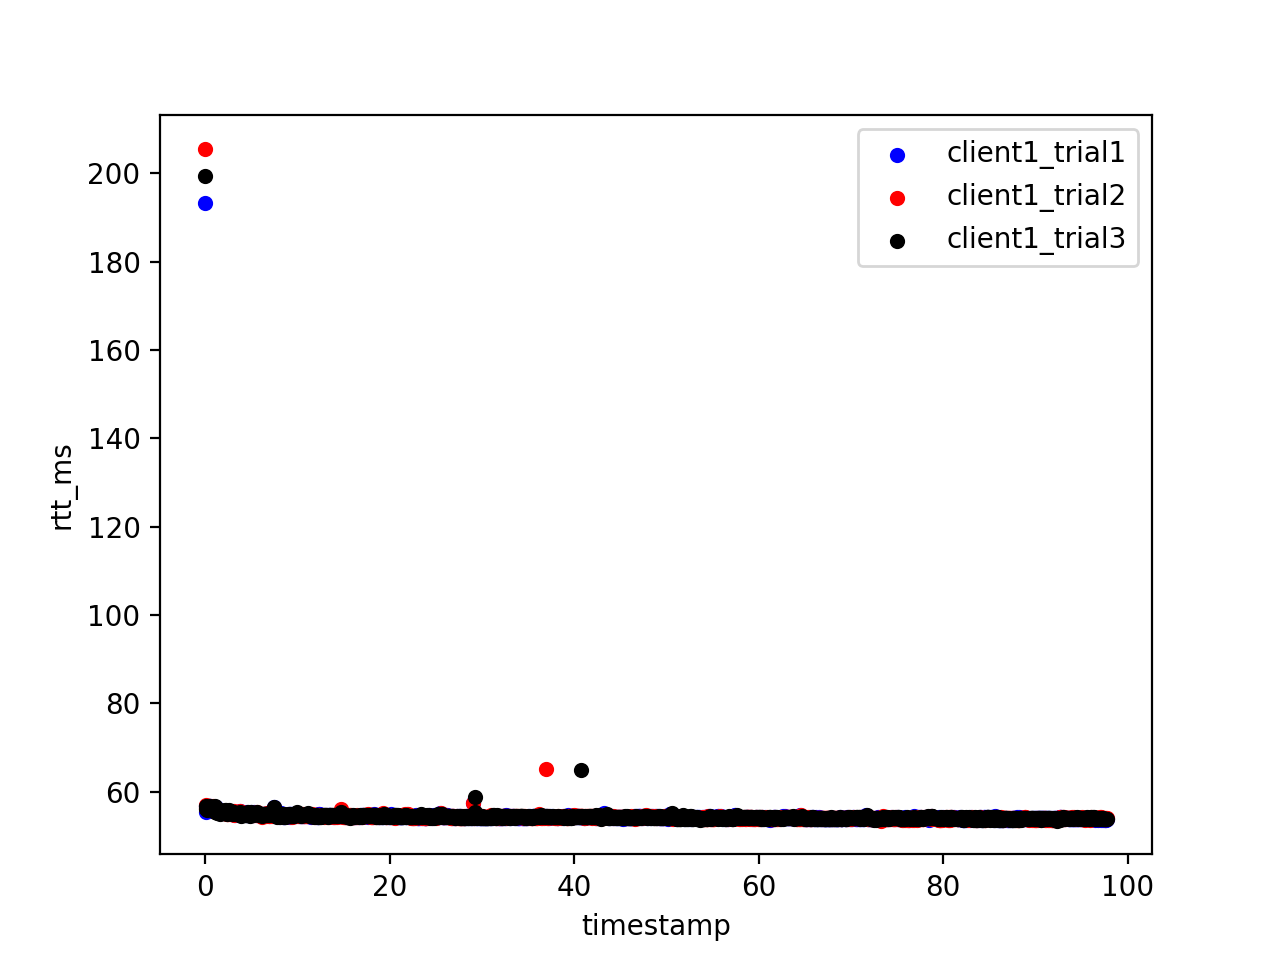

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [6]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {}

ax = None
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        if ax:
            client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, ax=ax, color=color_map[(client_number, t)])
        else:
            ax = client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, color=color_map[(client_number, t)])
plt.show()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<IPython.core.display.Javascript object>


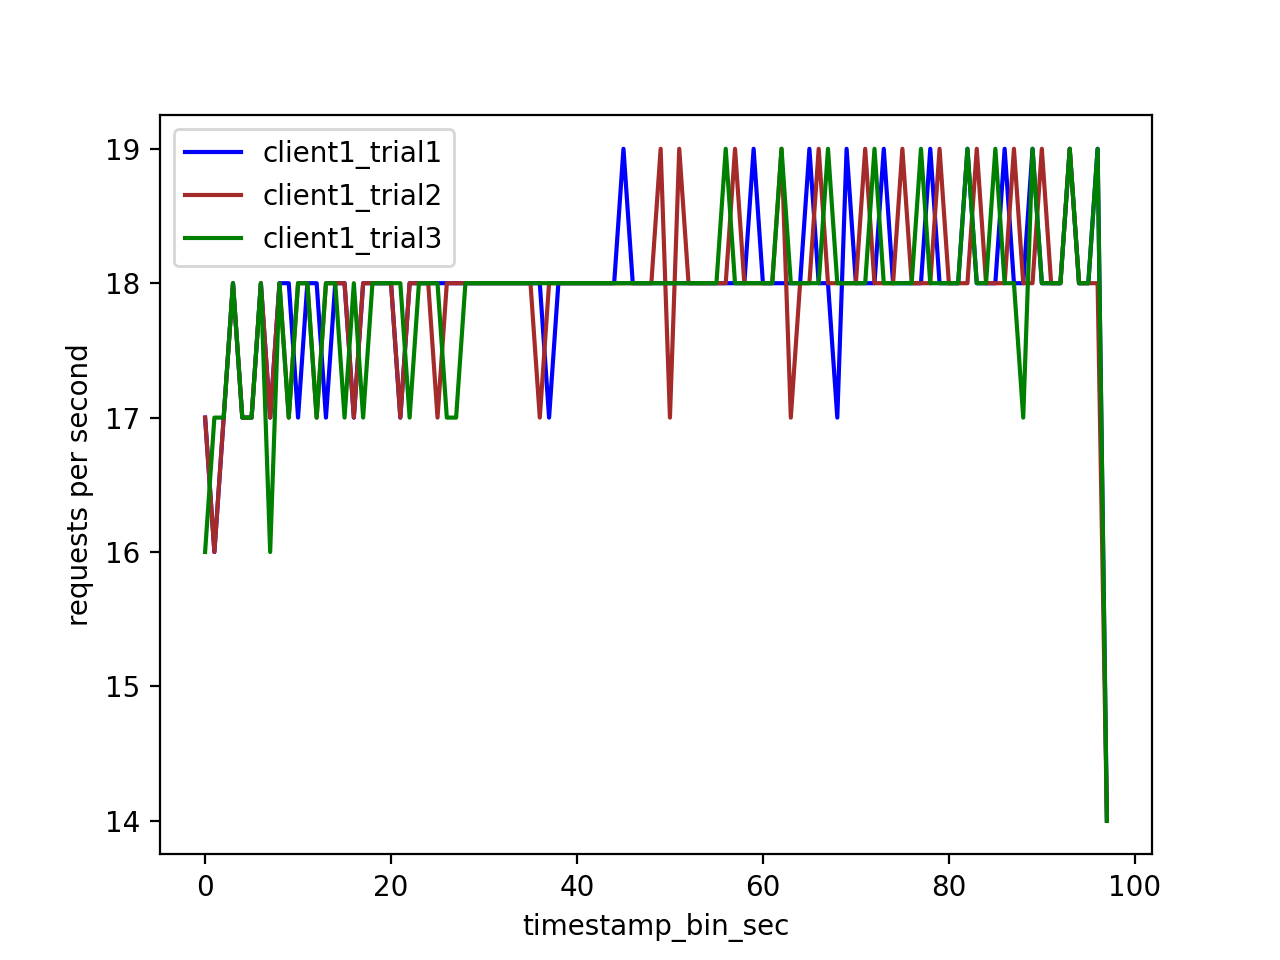

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,timestamp_bin_sec,src_id,packets_per_second,bytes_per_second
0,0.0,5,16,1703
1,1.0,5,17,1819
2,2.0,5,17,1819
3,3.0,5,18,1926
4,4.0,5,17,1819
...,...,...,...,...
93,93.0,5,19,2071
94,94.0,5,18,1962
95,95.0,5,18,1962
96,96.0,5,19,2071


In [7]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["timestamp"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "src_id"]).agg(\
                                             packets_per_second=("max_size_bytes", "count"),
                                             bytes_per_second=("max_size_bytes", "sum")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


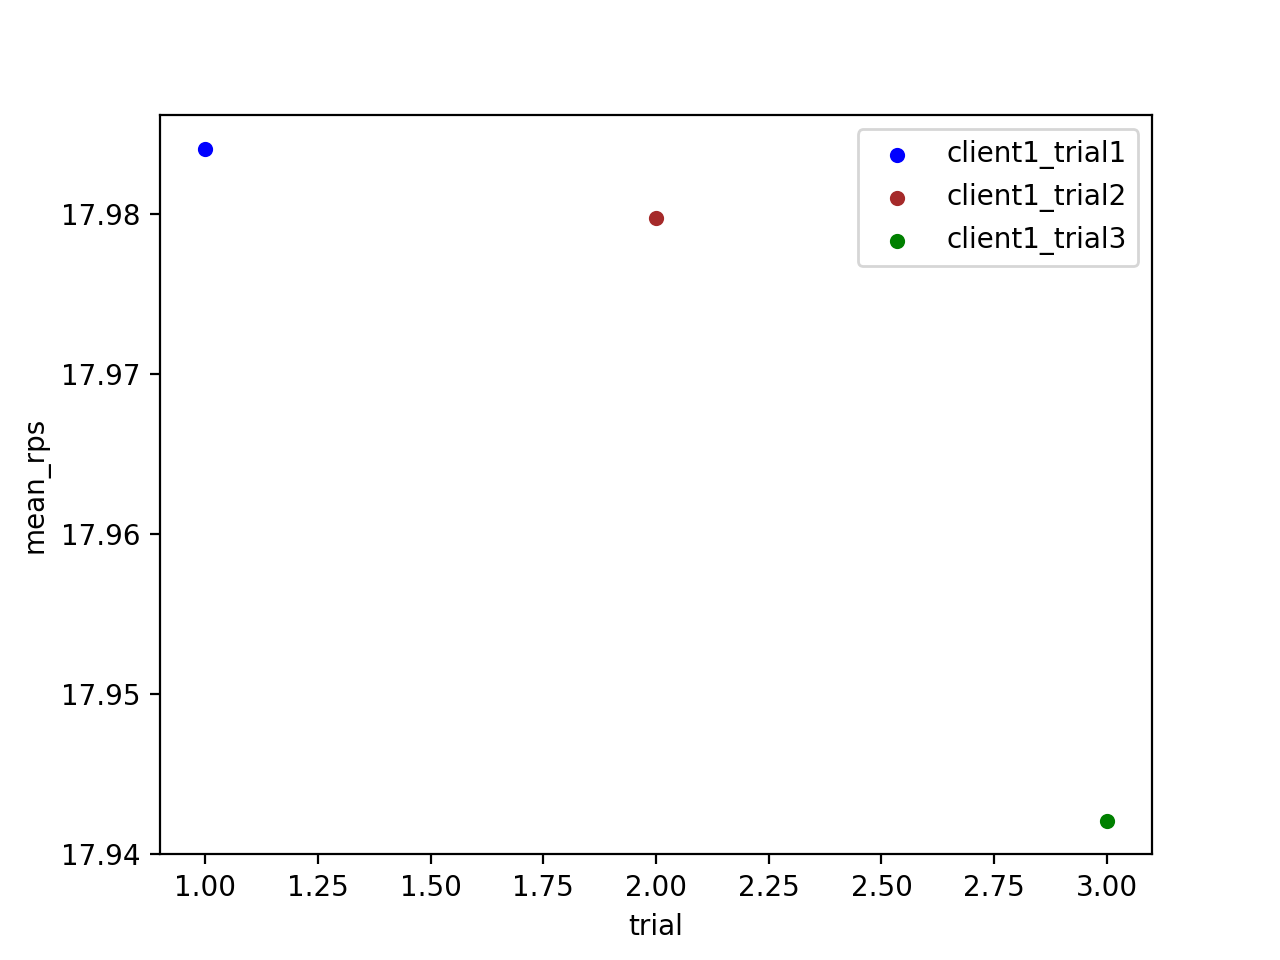

   trial   mean_rps
0      1  17.984109
1      2  17.979750
2      3  17.942068


,src_id,trial,mean_rps
0,5,1,17.984109
1,5,2,17.979750
2,5,3,17.942068


In [8]:
gdf = rtts_df.groupby(by=["src_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["src_id"].unique(), start=1):
        cdf = tdf[tdf["src_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
        
plt.show()

gdf